# Desafío 2: Rendimiento escolar
# Nombre: Jorge Hoffmann

# Hito 1 - Preliminares y aspectos computacionales

## Introducción al problema
Se busca generar un modelo que identifique a aquellos alumnos con bajo desempeño académico. Para esto, se cuenta con un data de registros sociodemográficos y conductuales de los alumnos de dos escuelas diferentes.

Existe además una batería de preguntas asociadas a aspectos ambientales del alumno. La idea es ver si estas se pueden abstraer en categorías latentes.

## Descripción de las variables
El vector objetivo es una variable continua que representa las notas de cada estudiante. Como cosa relevante, son 3: G1 (notas primer semestre), G2 (notas segundo semestre) y G3 (notas finales). Así, nos enfrentamos a un problema de regresión con un vector objetivo continuo.
Respecto a los atributos disponibles para modelar las notas, estos se listan a continuación. Se deberá validar cuáles funcionan mejor.
- School (a qué escuela pertenece el estudiante)
- Sex
- Age
- Ubicación urbana o rural
- Edad
- Tamaño de la familia
- Nivel educacional de los padres
- Ocupación de los padres
- Tiempo de viaje
- Horas destinadas al estudio
- Número de clases reprobadas
- Apoyo educacional del colegio
- Apoyo educacional familiar
- Clases particulares pagadas
- Actividades extracurriculares
- Asistió a guardería infantil
- Desea proseguir estudios superiores
- Acceso a internet desde el hogar
- Relación romántica
- Calidad de las relaciones familiares
- Tiempo libre fuera del colegio
- Salidas con amigos 
- Consumo de alcohol en día de semana 
- Consumo de alcohol en fines de semana 
- Estado de salud actual 
- absences: Cantidad de ausencias escolares 

## Métricas de evaluación
Dado que estamos frente a un problema de regresión, utilizaremos métricas de MSE, RMSE y R cuadrado para comparar los modelos.  
En particular, de cara al enfoque econométrico, podemos validar el R cuadrado. En cambio, será en el modelo de machine learning cuando podremos mirar MSE.

## Librerías a utilizar
A continuación, se comentarán librerías a utilizar. Podrían haber adicionales, pero estas son las principales.
- <strong>Pandas</strong> para contar con los dataframe
- <strong>Numpy</strong> para realizar cálculos
- <strong>matplotlib.pyplot</strong> para graficar
- <strong>seaborn</strong> para graficar
- <strong>de sklearn.metrics mean_squared_error</strong> para poder evaluar el MSE del modelo de regresión
- <strong>statsmodels.formula.api</strong> para realizar regresiones en el marco econométrico (con ols para regresión)
- <strong>de sklearn.linear_model LinearRegression</strong> para generar regresiones desde el machine learning 
- <strong>de sklearn.model_selection train_test_split</strong> para separar la data en train y test
- <strong>missingno</strong> para la inspección visual de valores nulos
- <strong>factor_analyzer</strong> para la abstracción de en categorías latentes

## Recodificación y operacionalización
De cara a operacionalizar, se presentan problemas con la data. Tales como, múltiples categorías de datos  perdidos, variables numéricas registradas como object. Esto deberá revisarse en cada caso para lograr el mejor resultado posible.  
Este será el punto de partida. A posteriori, se deberán recodificar todas las variables de tipo object, de modo que sean int. En ese caso, se usará Binary encoding cada vez que no exista una jerarquía clara dentro de las clases de la columna. En cambio, cuando sí exista jerarquía entre las clases, se puede utilizar Label encoding. 

# Hito 2 - Descripción
Inicialmente, cargaremos la data y haremos todos los import correspondientes. Esto incluye nuestro archivo de funciones auxiliares.

In [1]:
import Funciones as f_aux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as linreg
from sklearn.model_selection import train_test_split
import missingno as msn
import factor_analyzer as fact

# Seteamos para ignorar Warnings y no ensuciar el código por advertencias
import warnings
warnings.filterwarnings(action='ignore')

# Seteamos estilo dado que estoy con un tema oscuro
plt.style.use('seaborn')

# Leemos el df y eliminamos la columna unnamed
df = pd.read_csv('students.csv', sep = '|').drop(columns = ['Unnamed: 0'])
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,nulidade,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,sem validade,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


## Limpieza de cosas extrañas y estandarización de los np.nan

Se importa correctamente el archivo. Al hacer head() es evidente que los datos presentan múltiples problemas (datos nulos no son np.nan y hay números con ""), por ello, utilizaremos una función para limpiarlos.    
Esto se evidencia cuando construimos la matriz de missingno, pero no muestra vacíos.  
Es por esto que, previo a recodificar o a graficar, limpiaremos los datos.

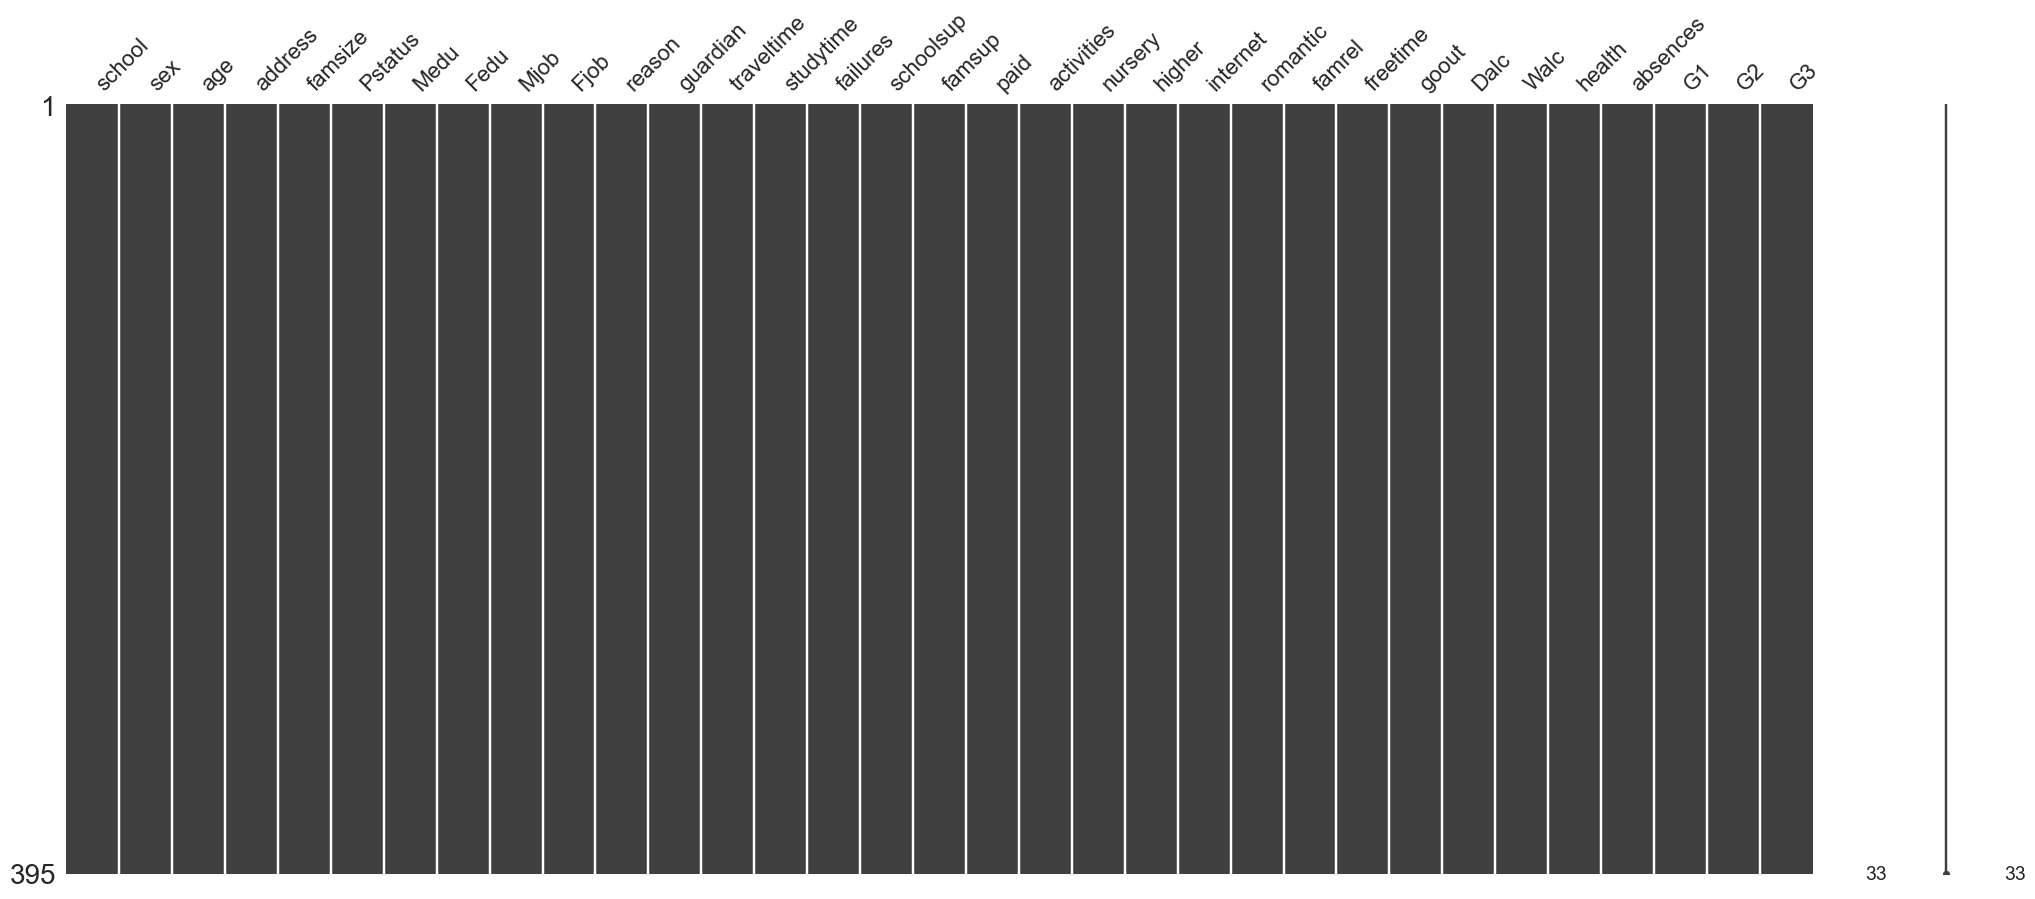

In [2]:
msn.matrix(df);

Esto puede resultar engañoso, ya que parece que no hay nulos.Así, debemos aplicar nuestra función para estandarizar datos nulos (transformarlos a np.nan). Adicionalmente, reemplazará las comillas por vacíos en las 3 variables numéricas mal cargadas

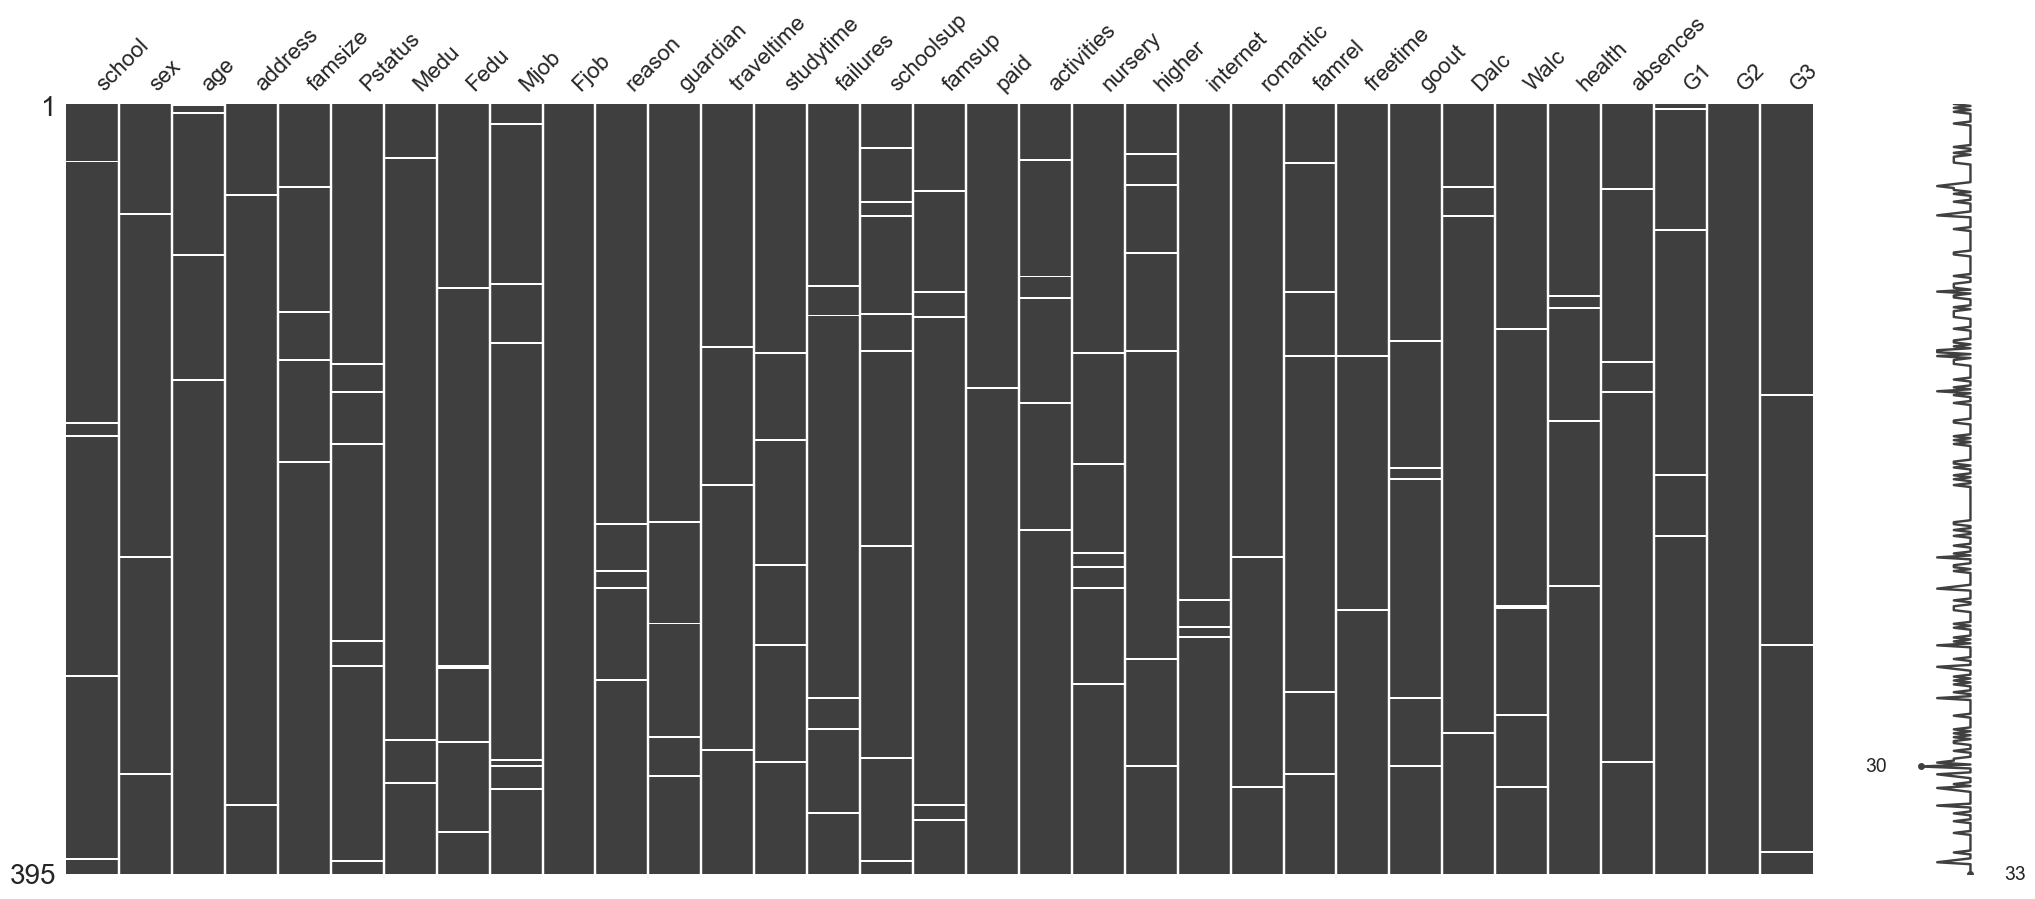

In [3]:
lista_nulos = ['nulidade', 'sem validade', 'zero']
cols_comillas = cols_comillas = ['age', 'goout', 'health']
df = f_aux.estandarizar_datos_nulos(df, lista_nulos, cols_comillas)
msn.matrix(df);

## Tratamiento de nulos y asignación de tipos
Partimos revisando si hay alguna columna que tenga un exceso de nulos. Para ello, construímos un gráfico de barras horizontal para poder ver los nombres de las columnas. Se observa que los nulos no están cargados en una columna, sino que distribuidos. Esto coincide con lo que vimos en la matriz de valores perdidos.

Text(0.5, 1.0, 'Conteo de valores perdidos para todas las columnas')

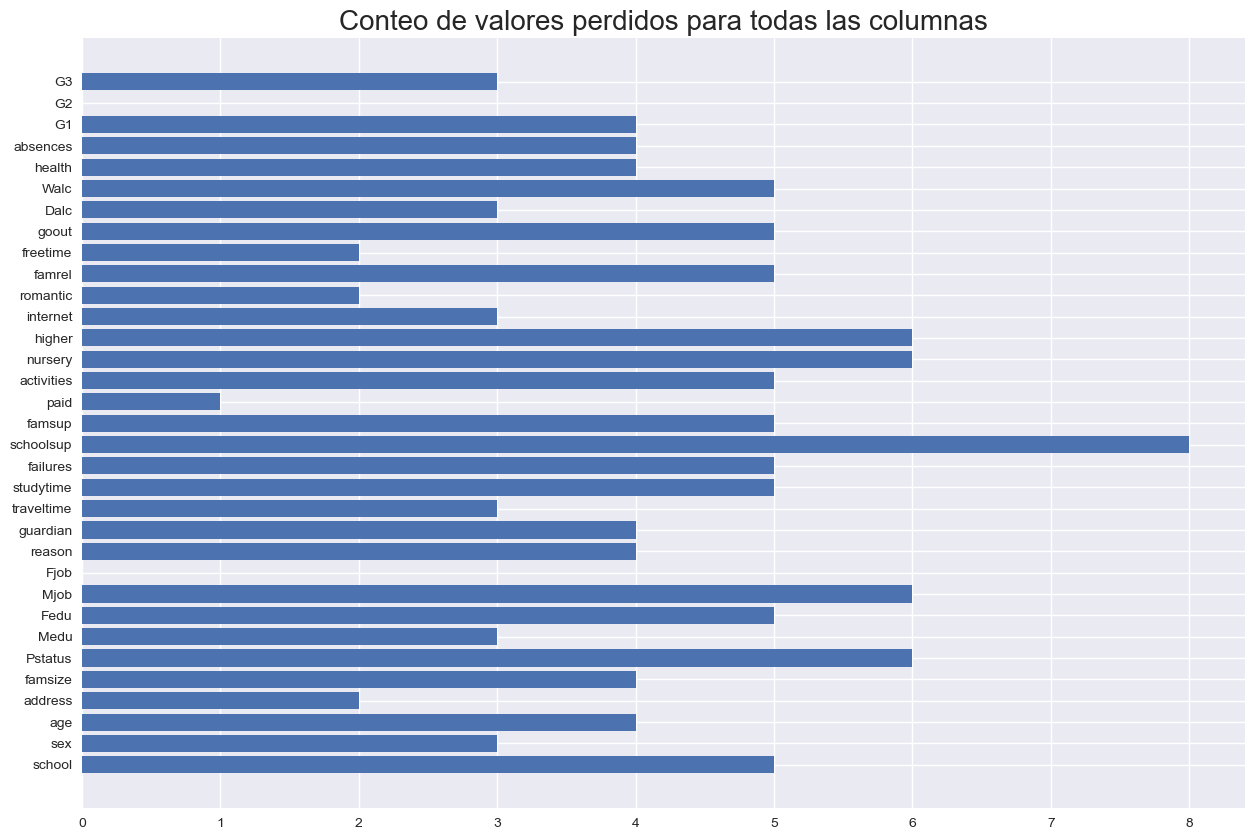

In [4]:
nulos = df.isna().sum()
plt.figure(figsize=(15,10))
plt.barh(nulos.index, width=nulos);
plt.title('Conteo de valores perdidos para todas las columnas', size = 20)

La siguiente celda realiza un drop de las filas con nulos en alguna columna. Para los valores resultantes, asigna tipo int cada vez que es posible. También resetea el índice. Todo lo anterior con una función externa. 

In [5]:
lista_columnas = list(df.columns)
df = f_aux.limpiar_dataFrame(df, lista_columnas)

Columna school no pudo ser transformada
Columna sex no pudo ser transformada
Columna age transformada a entero
Columna address no pudo ser transformada
Columna famsize no pudo ser transformada
Columna Pstatus no pudo ser transformada
Columna Medu transformada a entero
Columna Fedu transformada a entero
Columna Mjob no pudo ser transformada
Columna Fjob no pudo ser transformada
Columna reason no pudo ser transformada
Columna guardian no pudo ser transformada
Columna traveltime transformada a entero
Columna studytime transformada a entero
Columna failures transformada a entero
Columna schoolsup no pudo ser transformada
Columna famsup no pudo ser transformada
Columna paid no pudo ser transformada
Columna activities no pudo ser transformada
Columna nursery no pudo ser transformada
Columna higher no pudo ser transformada
Columna internet no pudo ser transformada
Columna romantic no pudo ser transformada
Columna famrel transformada a entero
Columna freetime transformada a entero
Columna goou

Como resultado, nuestro DataFrame ahora no tiene nulos en las columnas definidas como 'de interés'. 

## Inspección de variables

El siguiente paso, será hacer una inspección visual de qué variables estamos enfrentando y de cuál es su naturaleza.  

### Histogramas de notas para cada escuela

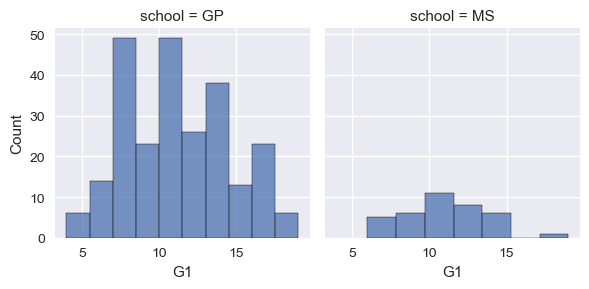

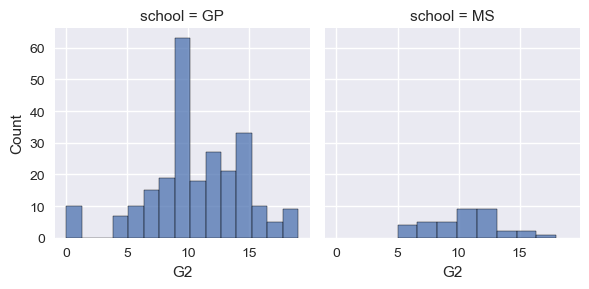

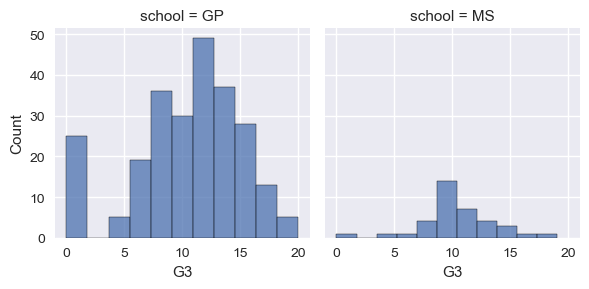

In [6]:
g1 = sns.FacetGrid(df, col_wrap = 2, col = 'school').map(sns.histplot, 'G1');
g2 = sns.FacetGrid(df, col_wrap = 2, col = 'school').map(sns.histplot, 'G2');
g3 = sns.FacetGrid(df, col_wrap = 2, col = 'school').map(sns.histplot, 'G3');
g1, g2, g3;

#### Comentarios:
Se observa que la escuela MS tiene una menor cantidad de estudiantes que GP. Sin embargo, las distribuciones son bastante similares. Esto, entre escuelas y para los distintos promedios, G1, G2 y G3.  
Si bien se observa que los gráficos concentran más datos hacia el centro y menos hacia los costados, no se ve que sigan una distribución normal. Esto sobre todo porque la normal debe ser unimodal, pero acá no se cumple. Con eso en mente, la distribución igual tiene forma de campana.


### Frecuencia para traveltime y studytime

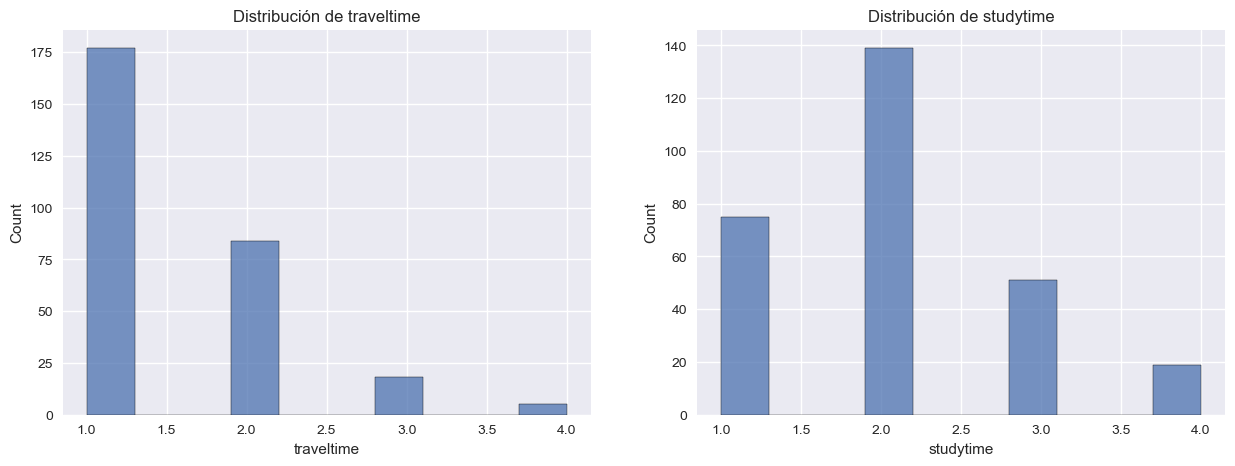

In [7]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
sns.histplot(df['traveltime']).set(title = 'Distribución de traveltime');
plt.subplot(1, 2, 2)
sns.histplot(df['studytime']).set(title = 'Distribución de studytime');

#### Comentarios
En cuanto a studytime, se observa que la mayor parte de las personas se encuentran en 2. Sin embargo, las clases no están tan desbalanceadas, salvo quizás el nivel 4. En cambio, para traveltime, si se observa que la mayoría viaja poco y pocos viajan mucho. Dada la baja frecuencia de los estratos más altos, podría ser deseable agrupar en nuevas categorías. Esto se deja como posibilidad de mejora.

### Scatter de notas según ausencias

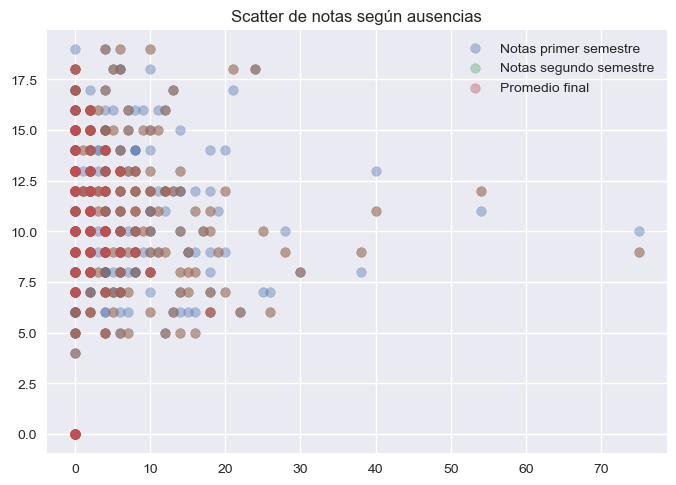

In [8]:
plt.scatter(x = df['absences'], y = df['G1'], label = 'Notas primer semestre', alpha = 0.4);
plt.scatter(x = df['absences'], y = df['G2'], label = 'Notas segundo semestre', alpha = 0.4);
plt.scatter(x = df['absences'], y = df['G2'], label = 'Promedio final', alpha = 0.4);
plt.legend();
plt.title('Scatter de notas según ausencias');

#### Comentarios:
Al construir el scatter con 'ausencias' en el eje x y los promedios en el eje y, no se observa diferencia al comparar los 3 promedios. Lo que sí se observa es que a mayor cantidad de ausencias, los promedios tienen a ser menores. Prueba de esto es que mientras más a la derecha en el gráfico, los promedios más altos van desapareciendo.

### Boxplot de G3 según study time y sex

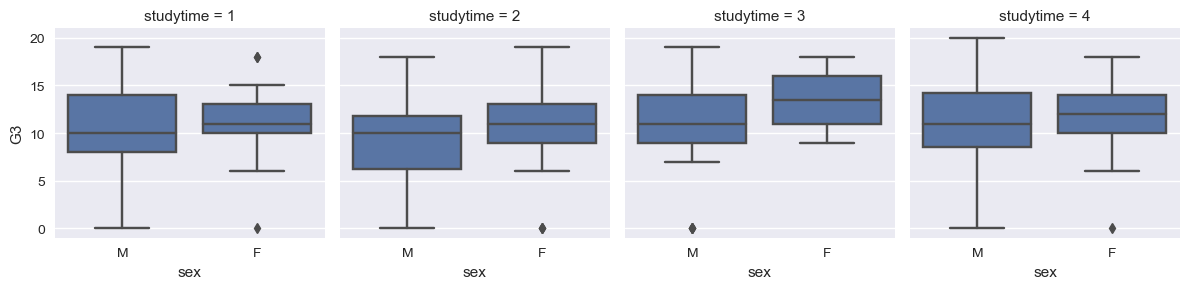

In [9]:
sns.FacetGrid(df, col = 'studytime').map(sns.boxplot, 'sex', 'G3');

#### Comentarios:
Se observan diferencias interesantes al tomar el estudy time 2 y 3, puesto que ahí las mujeres logran un mejor resultado. En cambio, en studytime 1 y 4 (poco y mucho), esto no se ve. Lo llamativo es esa diferencia en el comportamiento.

### Ausencias vs notas por género y escuela

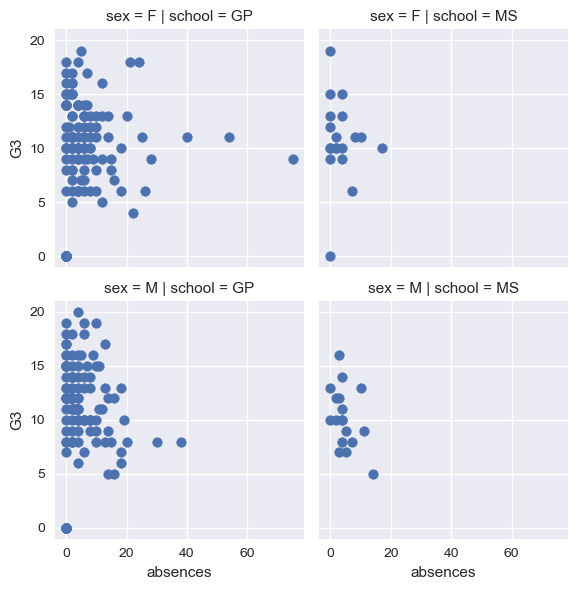

In [10]:
sns.FacetGrid(df, row = 'sex', col = 'school').map(plt.scatter, 'absences', 'G3');

#### Comentarios:
Se mantiene la conclusión que veíamos antes, tanto por género como por escuela. Una mayor cantidad de ausencias hace que los promedios tiendan a ser menores.  
Destaca en el gráfico anterior que las nubes de puntos asociadas a mujer y hombre no difieren en su tamaño, de modo que las muestras son similares.

### Correlación entre las notas

In [11]:
# Definimos correlación entre notas para cada colegio
df_corr_gp = df[df['school'] == 'GP'][['G1', 'G2', 'G3']].corr()
df_corr_ms = df[df['school'] == 'MS'][['G1', 'G2', 'G3']].corr()

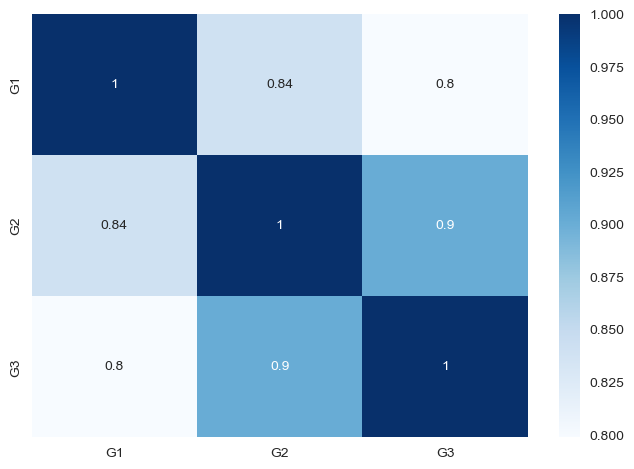

In [12]:
sns.heatmap(df_corr_gp, cmap = 'Blues', annot = True);

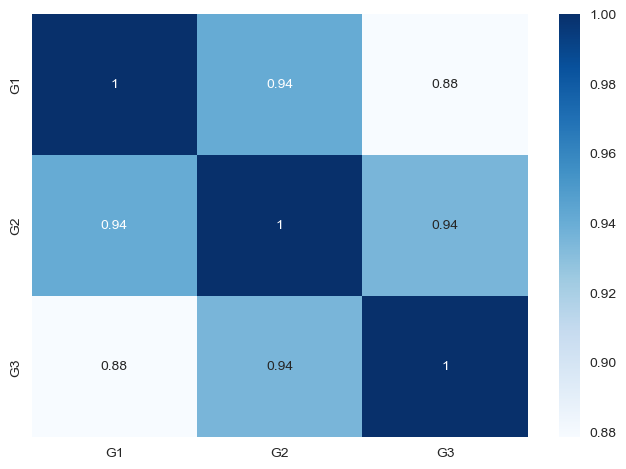

In [13]:
sns.heatmap(df_corr_ms, cmap = 'Blues', annot = True);

#### Comentarios:
En ambos colegios las notas están altamente correlacionadas. Ahora, G3 es el promedio entre G1 y G2, de modo que trivialmente debe existir correlación. Sin embargo, también hay alta correlación entre G1 y G2. Eso habla de cierta consistencia en las notas de los alumnos.


## Recodificación
En esta sección, recodificaremos las distintas columnas


In [14]:
#Primero, clasificaremos nuestras columnas en 2 grupos. Ya son continuas y hay que aplicar get_dummies
cols_mantienen = ['famrel', 'freetime', 'goout', 'Dalc','Walc', 'health', 'absences', 
                  'G1', 'G2', 'G3', 'failures', 'age','Medu', 'Fedu', 'studytime', 'traveltime' ]

cols_get_dummies = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery','higher', 
                    'internet', 'romantic', 'Mjob', 'Fjob', 'reason', 'guardian', 
                    'Pstatus', 'address', 'famsize','school', 'sex', ]

df_mantienen = df[cols_mantienen]
df_dummies = pd.get_dummies(df[cols_get_dummies], drop_first = True)
df_final = pd.concat([df_mantienen, df_dummies], axis = 1)
df_final.head()

,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,...,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,Pstatus_T,address_U,famsize_LE3,school_MS,sex_M
0,5,3,3,1,1,3,4,5,5,6,...,0,0,0,0,0,1,1,0,0,0
1,3,2,2,1,1,5,2,15,14,15,...,1,0,0,1,0,1,1,0,0,0
2,5,4,2,1,2,5,10,15,15,15,...,0,0,1,1,0,1,1,1,0,1
3,4,4,4,1,1,3,0,12,12,11,...,1,0,0,1,0,1,1,1,0,1
4,4,1,4,1,1,1,6,6,5,6,...,1,0,0,1,0,0,1,0,0,0


Nuestro df final, listo para aplicar los modelos, tiene 42 columnas habiendo recodificado todo, habiendo aplicado binary encoding y label encoding.

# Hito 3 - 

## Análisis de variables latentes


Partimos realizando nuestro análisis de variable latentes para las columnas que van de famreal a health.

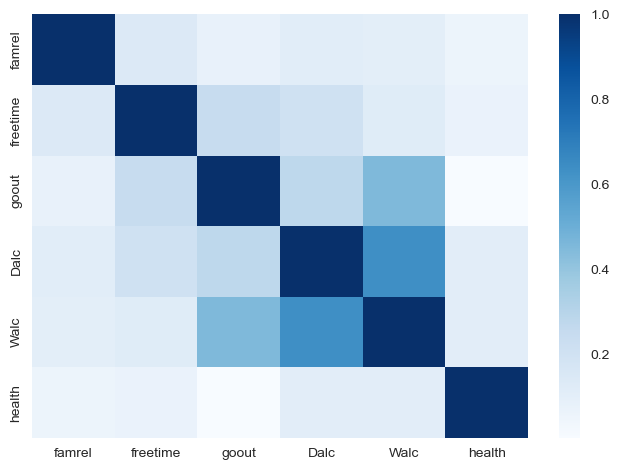

In [15]:
df_candidatas_latentes = df_final.loc[:, 'famrel':'health']
sns.heatmap(df_candidatas_latentes.corr().abs(), cmap = 'Blues', annot = False);

In [16]:
# Generamos la prueba de bartlett
estadistico, p_valor = fact.calculate_bartlett_sphericity(df_candidatas_latentes)
p_valor

6.038167101274183e-48

el p_Value de la prueba de Bartlett es menor a 0.05, de modo que se puede seguir.

In [17]:
# Generamos el test kmo
kmos_individuales, kmo_general = fact.calculate_kmo(df_candidatas_latentes)
kmos_individuales, kmo_general

(array([0.50173343, 0.57692329, 0.61683967, 0.58664172, 0.5554092 ,
        0.59265861]),
 0.5767240731164608)

Lamentablemente, el KMO general no es mayor a 0.7, ni siquiera a 0.6. Esto nos impide seguir con el análisis de variables latentes, pese a las recomendaciones del mandante.

## Modelación descriptiva
En esta sección, se presenta la modelación descriptiva considerando 3 vectores objetivos diferentes. En los 3 casos se presenta un modelo saturado y uno depurado.

El nivel de significancia que utilizaremos es 0.05. Si bien resulta tentador aumentarlo de modo de tener más variables estadísticamente significativas, no sería correcta dado que es una definición a priori.

In [18]:
columnas_modelo_1 = list(df_final.columns)
columnas_modelo_1.remove('G2') # Extraemos el otro promedio pq sí o sí daría significativa
columnas_modelo_1.remove('G3') # Extraemos el otro promedio pq sí o sí daría significativa

formula_modeloG1_1 = f_aux.generar_formula_regresion(columnas_modelo_1, 'G1')
modeloG1_1 = smf.ols(formula_modeloG1_1, df_final).fit()
resultadoG1_1 = modeloG1_1.summary2().tables[1]
resultadoG1_1[resultadoG1_1['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,10.148669,3.682429,2.755971,0.006294,2.895263,17.402076
goout,-0.769110,0.198592,-3.872824,0.000138,-1.160283,-0.377938
health,-0.291802,0.141512,-2.062038,0.040263,-0.570542,-0.013062
failures,-1.123512,0.282493,-3.977132,0.000092,-1.679948,-0.567076
studytime,0.507365,0.245359,2.067842,0.039709,0.024072,0.990657
schoolsup_yes,-1.773727,0.563935,-3.145266,0.001865,-2.884530,-0.662924
famsup_yes,-1.006158,0.411207,-2.446843,0.015118,-1.816126,-0.196190


In [19]:
columnas_modelo_1 = list(df_final.columns)
columnas_modelo_1.remove('G3')
columnas_modelo_1.remove('G1')

formula_modeloG2_1 = f_aux.generar_formula_regresion(columnas_modelo_1, 'G2')
modeloG2_1 = smf.ols(formula_modeloG2_1, df_final).fit()
resultadoG2_1 = modeloG2_1.summary2().tables[1]
resultadoG2_1[resultadoG2_1['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,12.351271,4.335277,2.849015,0.004760,3.811928,20.890614
goout,-0.965529,0.233799,-4.129734,0.000050,-1.426052,-0.505007
health,-0.390113,0.166600,-2.341616,0.020006,-0.718270,-0.061955
failures,-1.129301,0.332575,-3.395623,0.000799,-1.784386,-0.474216
famsup_yes,-1.002347,0.484108,-2.070501,0.039457,-1.955911,-0.048782


In [20]:
columnas_modelo_1 = list(df_final.columns)
columnas_modelo_1.remove('G1')
columnas_modelo_1.remove('G2')

formula_modeloG3_1 = f_aux.generar_formula_regresion(columnas_modelo_1, 'G3')
modeloG3_1 = smf.ols(formula_modeloG3_1, df_final).fit()
resultadoG3_1 = modeloG3_1.summary2().tables[1]
resultadoG3_1[resultadoG3_1['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,11.834346,5.184156,2.282791,0.023304,1.622938,22.045755
goout,-1.239566,0.279579,-4.433687,0.000014,-1.790262,-0.688869
Walc,0.756554,0.295340,2.561635,0.011020,0.174812,1.338296
health,-0.393640,0.199221,-1.975893,0.049294,-0.786052,-0.001227
failures,-1.476681,0.397696,-3.713089,0.000254,-2.260037,-0.693326


Las 3 tablas anteriores corresponden a los resultados de la modelación de las 3 variables dependientes. A continuación, usaremos estas variables para construir 3 modelos nuevos depurados. Los resultados de estos modelos quedaron guardados en ResultadoG1_1, ResultadoG2_1 y ResultadoG3_1. 

In [21]:
columnas_modelo_2 = list(resultadoG1_1[resultadoG1_1['P>|t|'] < 0.05].index)[1:] # Excluimos el intercepto
formula_modeloG1_2 = f_aux.generar_formula_regresion(columnas_modelo_2, 'G1')
modeloG1_2 = smf.ols(formula_modeloG1_2, df_final).fit()
resultadoG1_2 = modeloG1_2.summary2().tables[1]
resultadoG1_2[resultadoG1_2['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,13.956530,0.899051,15.523618,1.568502e-39,12.186689,15.726371
goout,-0.564530,0.166206,-3.396558,7.824024e-04,-0.891718,-0.237342
failures,-1.254817,0.247425,-5.071498,7.236502e-07,-1.741890,-0.767744
schoolsup_yes,-1.977866,0.521812,-3.790383,1.846014e-04,-3.005086,-0.950646


#### Comentarios
Se observa que al modelar G1, solo 3 variables resultan estadísticamente significativas.
- Aumentar goout implica que el resultado del primer semestre empeora. Esto hace sentido, puesto que es un estudiante que puede distraerse.
- failures también afecta negativamente el promedio. Se podría interpretar como que por cada clase reprobada en promedio la nota baja 1.25. La anterior interpretación tiene la salvedad de que si Failure fuese mayor a 4, la variable igual queda en 4 (numérica: n si 1<=n<3, de lo contrario 4). Sin embargo, en el rango de 0 a 4 sí coincide la interpretación.
- Se destaca que alumnos con schoolsup tienen un peor rendimiento. En promedio, aquellos que tienen schoolsup tiene 2 puntos menos de nota. Esto tiene sentido ya que requieren de mayor ayuda seguramente.

In [22]:
columnas_modelo_2 = list(resultadoG2_1[resultadoG2_1['P>|t|'] < 0.05].index)[1:] # Excluimos el intercepto
formula_modeloG2_2 = f_aux.generar_formula_regresion(columnas_modelo_2, 'G2')
modeloG2_2 = smf.ols(formula_modeloG2_2, df_final).fit()
resultadoG2_2 = modeloG2_2.summary2().tables[1]
resultadoG2_2[resultadoG2_2['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,14.848412,0.885421,16.769884,3.905415e-44,13.105458,16.591367
goout,-0.652064,0.195803,-3.330194,9.847395e-04,-1.037503,-0.266624
health,-0.353349,0.158384,-2.230968,2.647812e-02,-0.665128,-0.041570
failures,-1.470304,0.289688,-5.075466,7.070554e-07,-2.040557,-0.900051


#### Comentarios
Al modelar G2, se observan resultados bastante similares. 
- Existe la salvedad de que schoolsup no incide en este caso. Esto puede ser porque alumnos apoyados educacionalmente con el colegio tienen peores resultados en G1, sin embargo, con el correr del tiempo se ponen al día.
- Llama la atención de que estudiantes con mejor 'health' tienen peores notas. A priori, puede parecer extraño. Habría que profundizar si es una anomalía en la data o si realmente es así. En este caso, el trade off entre Health y notas puede ser muy relevante como conclusión del estudio.

In [23]:
columnas_modelo_3 = list(resultadoG3_1[resultadoG3_1['P>|t|'] < 0.05].index)[1:] # Excluimos el intercepto
formula_modeloG3_2 = f_aux.generar_formula_regresion(columnas_modelo_3, 'G3')
modeloG3_2 = smf.ols(formula_modeloG3_2, df_final).fit()
resultadoG3_2 = modeloG3_2.summary2().tables[1]
resultadoG3_2[resultadoG3_2['P>|t|'] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,14.273966,1.023022,13.952749,6.329484e-34,12.260144,16.287788
goout,-0.964077,0.261771,-3.682899,2.768695e-04,-1.479374,-0.448779
Walc,0.461012,0.219825,2.097176,3.687799e-02,0.028285,0.893738
failures,-1.992187,0.348447,-5.717335,2.779370e-08,-2.678105,-1.306268


In [24]:
columnas_modelo_3

['goout', 'Walc', 'health', 'failures']

#### Comentarios
En cuanto a la tercera regresión, Health deja de jugar un valor relevante. En este caso, el consumo de alcohol mejora las notas. Ahora, este es el consumo en fines de semana. Es posible que sean estudiantes que en la semana son muy aplicados, pero en el fin de semana se relajan. Quizás esta relajación les permite rendir mejor. 

### Comentarios generales
Lamentablemente, el DataFrame no tiene una cantidad de datos tan grande. Esto implica que las conclusiones entregadas deben ser tomadas con cuidado.

En particular, se observa que el consumo de alcohol en los fines de semana mejora el rendimiento de los estudiantes. Esto puede parecer extraño. Si bien existe una interpretación que calza, es una conclusión bastante fuerte como para tomarla a la ligera. Asimismo, que estudiantes más sanos tienen peor rendimiento también resulta contraintuitivo. Estos podrían ser trade offs importantes de cara al estudio y por lo mismo se sugiere mayor analisis.

### Bondad de ajuste
 A continuación, se muestra el R cuadrado para cada una de las pareajs de los modelos.

In [25]:
r = pd.DataFrame(
    data =  [
        [modeloG1_1.rsquared, modeloG1_2.rsquared],
        [modeloG2_1.rsquared, modeloG2_2.rsquared],
        [modeloG3_1.rsquared, modeloG3_2.rsquared]],
    columns = ['Modelo saturado', 'Modelo depurado'],
    index = ['Modelo G1', 'Modelo G2', 'Modelo G3'])
r

,Modelo saturado,Modelo depurado
Modelo G1,0.330600,0.208262
Modelo G2,0.300913,0.160591
Modelo G3,0.311506,0.168062


En los 3 casos, el R cuadrado de la versión saturada del modelo es mejor con una diferencia bastante clara. Sin embargo, sabemos que siempre al agregar más variables aumentará este indicador. 
A continuación se presentan los R cuadrados ajustados, los que castigan los modelos que incluyen una cantidad excesiva de variables.

In [26]:
r = pd.DataFrame(
    data =  [
        [modeloG1_1.rsquared_adj, modeloG1_2.rsquared_adj],
        [modeloG2_1.rsquared_adj, modeloG2_2.rsquared_adj],
        [modeloG3_1.rsquared_adj, modeloG3_2.rsquared_adj]],
    columns = ['Modelo saturado', 'Modelo depurado'],
    index = ['Modelo G1', 'Modelo G2', 'Modelo G3'])
r

,Modelo saturado,Modelo depurado
Modelo G1,0.223606,0.191113
Modelo G2,0.189174,0.148557
Modelo G3,0.201460,0.156135


Vemos que al tomar el R cuadrado ajustado la diferencia disminuye. Si bien el modelo saturado sigue presentando mejores resultados, la brecha entre ambos disminuyó considerablemente.

## Opciones modelación
A continuación, se muestran 3 potenciales modelos predictivos a construir en el Hito 4:
- Modelo con todas las variables
- Solo las que resultaron estadísticamente significativas en el estudio econométrico de G1, G2 o G3
- Mismas que el ítem 2, pero normalizadas y sin intercepto

## Hito 4
En la presente sección construiremos 3 modelos predictivos y los evaluaremos. Esto según la definición hecha en el hito 3.

Cabe destacar que, de cara a obtener buenos resultados, no se utilizarán G1 y G2 para predecir G3. Esto porque el tercero es consecuencia directa de los otros 2, de modo que incluirlo mejoraría mucho el modelo, pero la predicción dejaría de ser necesaria.

In [27]:
# Modelo saturado: todas las columnas del dataframe
columnas_modelo_1 = list(df_final.columns)
columnas_modelo_1.remove('G1')
columnas_modelo_1.remove('G2')
columnas_modelo_1.remove('G3')

# Modelo depurado. Union de las columnas de los 3 modelos econométricos. Aplciamos set para no repetir
columnas_modelo_2 = list(set(
    list(resultadoG1_2[resultadoG1_2['P>|t|'] < 0.05].index)[1:] +
    list(resultadoG2_2[resultadoG2_2['P>|t|'] < 0.05].index)[1:] +
    list(resultadoG3_2[resultadoG3_2['P>|t|'] < 0.05].index)[1:]))

# Modelo 3: mismas columnas que el depurado.
columnas_modelo_3 = columnas_modelo_2.copy() 

In [28]:
y_vec = df_final.pop('G3')
X_mat = df_final

Generamos el split entre train y test. Destacar que este se hace sobre todo el DataFrame en caso de la matriz X. Esto es porque a posteriori se tomarán las columnas de acuerdo a cada modelo.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=.33, random_state=11238)

Generamos, para cada modelo, un set de prueba y un set de entrenamiento. Cada uno con sus columnas respectivas.  
Luego, generamos 3 modelos con linreg() y los entrenamos con los datos respectivos.

In [30]:
X_train_1 = X_train[columnas_modelo_1]
X_train_2 = X_train[columnas_modelo_2]
X_train_3 = X_train[columnas_modelo_3]

X_test_1 = X_test[columnas_modelo_1]
X_test_2 = X_test[columnas_modelo_2]
X_test_3 = X_test[columnas_modelo_3]

Se destaca que los primeros dos modelos no están normalizados y consideran intercepto, en cambio, el tercero no usa intercepto y sí normaliza.

In [31]:
modelo_ML_1 = linreg(fit_intercept=True, normalize=False).fit(X_train_1, y_train)
modelo_ML_2 = linreg(fit_intercept=True, normalize=False).fit(X_train_2, y_train)
modelo_ML_3 = linreg(fit_intercept=False, normalize=True).fit(X_train_3, y_train)

In [32]:
modelo_1_yhat = modelo_ML_1.predict(X_test_1) 
modelo_2_yhat = modelo_ML_2.predict(X_test_2) 
modelo_3_yhat = modelo_ML_3.predict(X_test_3) 

In [33]:
print('Resultado del modelo saturado:')
f_aux.report_scores(modelo_1_yhat, y_test)
print()
print('Resultado del modelo depurado:')
f_aux.report_scores(modelo_2_yhat, y_test)
print()
print('Resultado del modelo depurado normalizado sin intercepto:')
f_aux.report_scores(modelo_3_yhat, y_test)

Resultado del modelo saturado:
Error Cuadrático Promedio: 21.3
Raiz del Error Cuadrático Promedio: 4.6
R2: -0.0

Resultado del modelo depurado:
Error Cuadrático Promedio: 19.0
Raiz del Error Cuadrático Promedio: 4.4
R2: 0.1

Resultado del modelo depurado normalizado sin intercepto:
Error Cuadrático Promedio: 37.6
Raiz del Error Cuadrático Promedio: 6.1
R2: -0.8


La celda anterior comprueba lo que vimos con los modelos econométricos. La combinación lineal de las columnas utilizadas (incluyendo age al cuadrado por ejemplo) no explica de buena forma G3. Esto se observa ya que incluso tenemos R cuadrado negativo en el primer modelo (saturado) y en el tercero (sin intercepto y normalizado).
- Modelo saturado: con tantas variables y tan pocas observaciones, posiblemente ocurrió que modelamos ruido. Así, cuando pasamos de nuestros datos de train a nuestros de tes, los resultados fueron muy malos.
- Modelo depurado sin intercepto: probablemente al quitar el intercepto, le quitamos rango de acción a la regresión. De modo que el resultado es un modelo que no explica en absoluto la variabilidad de los datos.
- Modelo depurado con intercepto: Este modelo es el que menor error cuadrático tiene, así como también explica un 10% de la varianza. Es un número bajo, pero mejor que los otros modelos. Además, equivocarse en promedio al predecir la nota en 4.4 puntos es bastante en una escala de 0 a 20.

En conclusión, no fue posible, ni con el enfoque econométrico ni con el enfoque de machine learning, generar modelos que expliquen las variaciones de G3 a partir de las variables independientes.